# Project 3: Web APIs & NLP

#### by Ian Stack

### Problem Statement

Can I predict which subreddit posts came from r/nhl vs. r/nba?

Professional sports has become one of the biggest entertainment businesses and captures indviduals all over the world.  In particular, the professional sports league: NHL and NBA are well known leagues with multiple teams throughout the United States. Both the NBA and NHL have a large fanbase and opinions are commonly shared on reddit.  I was hired by both the NBA and NHL to review the subreddit pages per each league and ensure that operations are running correctly.  It is my job to make sure that individual's posts are being posted on the correct subreddit. 

In this project I will be utilizing Pushshit Reddit API to obtain the "NBA" and "NHL" subreddit pages from Reddit.  I will utilize Multinominal Naive Bayes, K-nearest Neighbor, and Logistic Regression modeling and will be evaluated via accuracy on predicting whether the user's post came from r/nba or r/nhl.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier


import nltk
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS


from textblob import TextBlob

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ianst\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
nba_new = pd.read_csv('./p3_datasets/data/nba.csv')
nhl_new = pd.read_csv('./p3_datasets/data/nhl.csv')


#### Exploring & Cleaning of NBA subreddit

In [3]:
nba_new.head()

,Unnamed: 0,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,...,thumbnail_height,thumbnail_width,url_overridden_by_dest,author_flair_template_id,crosspost_parent,crosspost_parent_list,suggested_sort,banned_by,author_cakeday,edited
0,0,[],False,ProShowerSinger,NaN,[],NaN,text,t2_151a7x,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,[],False,talentpun,Raptors7,"[{'e': 'text', 't': 'Raptors'}]",Raptors,richtext,t2_lf95h,False,...,78.0,140.0,https://streamable.com/tqvl4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,[],False,LaMeloBallSoHard,Knicks3,"[{'a': ':nyk-3:', 'e': 'emoji', 'u': 'https://...",:nyk-3: Knicks,richtext,t2_2p7rvjvk,False,...,NaN,NaN,NaN,d5dcc2c0-3feb-11e8-8d0b-0e1d1ff4db48,NaN,NaN,NaN,NaN,NaN,NaN
3,3,[],False,Latrell-Sprewell,ESP,"[{'a': ':ESP:', 'e': 'emoji', 'u': 'https://em...",:ESP: Spain,richtext,t2_35b9m70t,False,...,77.0,140.0,https://twitter.com/squaresense/status/1428162...,1dadb4b0-e6b5-11eb-8289-0e52813c43fb,NaN,NaN,NaN,NaN,NaN,NaN
4,4,[],False,kirphioc2004,Warriors3,"[{'e': 'text', 't': '[GSW] Kevin Durant'}]",[GSW] Kevin Durant,richtext,t2_4s4z4qk0,False,...,105.0,140.0,https://www.youtube.com/watch?v=Fip6I6ggwL8&am...,c6cc8ebe-3feb-11e8-898f-0e174a61fc9c,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# number of unique 'titles'
nba_new['title'].nunique()

2886

In [5]:
nba_new.shape

(3000, 82)

In [6]:
# NBA Dataframe with `subreddit`, `selftext`, and `title` columns
pd.set_option('display.max_columns', None)
nba_new = nba_new[['subreddit', 'selftext', 'title']]

In [7]:
nba_new.head()

,subreddit,selftext,title
0,nba,[**Ra asked me**](https://mediumlights.substac...,OC: Rookies Adjusting To The NBA (easier for s...
1,nba,NaN,One of the highest upvoted posts and greatest ...
2,nba,#[Game 4 vs Portland](https://www.basketball-r...,2020 Lakers were up at least 30 points in each...
3,nba,NaN,Chicago Bears Coach Matt Nagy Uses Giannis NBA...
4,nba,NaN,Kevin Durant Takes Over In 2012 NBA Finals Gam...


In [8]:
nba_new.isnull().sum()

subreddit       0
selftext     1286
title           0
dtype: int64

In [9]:
# Save it
nba_new.to_csv('./datasets/nba_new')

In [10]:
nhl_new.head()

,Unnamed: 0,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_created_from_ads_ui,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,pwls,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,thumbnail,title,total_awards_received,treatment_tags,upvote_ratio,url,whitelist_status,wls,link_flair_template_id,link_flair_text,crosspost_parent,crosspost_parent_list,post_hint,preview,thumbnail_height,thumbnail_width,url_overridden_by_dest,author_flair_background_color,author_flair_template_id,author_flair_text_color,media,media_embed,secure_media,secure_media_embed,gallery_data,is_gallery,media_metadata,poll_data,removed_by_category,link_flair_css_class,author_cakeday,edited,suggested_sort,banned_by
0,0,[],False,akromyk,NaN,[],NaN,text,t2_htlnd,False,False,False,[],False,False,1629345048,self.nhl,https://www.reddit.com/r/nhl/comments/p77a5y/w...,{},p77a5y,False,True,False,False,False,True,True,False,NaN,[],dark,text,False,False,True,0,0,False,all_ads,/r/nhl/comments/p77a5y/whats_this_ive_been_hea...,False,6,1629345059,1,Can someone fill me in on what's going on with...,True,False,False,nhl,t5_2qrrq,251100,public,self,What's this I've been hearing about turning NH...,0,[],1.0,https://www.reddit.com/r/nhl/comments/p77a5y/w...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,[],False,akromyk,NaN,[],NaN,text,t2_htlnd,False,False,False,[],False,False,1629344626,self.nhl,https://www.reddit.com/r/nhl/comments/p776d2/e...,{},p776d2,False,True,False,False,False,True,True,False,NaN,"[{'e': 'text', 't': 'Question'}]",dark,richtext,False,False,True,0,0,False,all_ads,/r/nhl/comments/p776d2/eli5_whats_this_about_t...,False,6,1629344637,1,"I can't watch local games, I can't play the si...",True,False,False,nhl,t5_2qrrq,251100,public,self,ELI5: What's this about turning NHL jerseys in...,0,[],1.0,https://www.reddit.com/r/nhl/comments/p776d2/e...,all_ads,6,401cd922-ce91-11eb-b867-0ed60675cd25,Question,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,[],False,billpat-joe-dinosuar,NaN,[],NaN,text,t2_27n7a0ke,False,False,False,[],False,False,1629341075,v.redd.it,https://www.reddit.com/r/nhl/comments/p768dv/h...,{},p768dv,False,True,False,False,True,True,False,False,NaN,[],dark,text,False,False,True,0,0,False,all_ads,/r/nhl/comments/p768dv/hockey_player_hits_russ...,False,6,1629341087,1,NaN,True,False,False,nhl,t5_2qrrq,251096,public,https://a.thumbs.redditmedia.com/KjRfWo-fAVnJS...,Hockey player hits Russian Referee,0,[],1.0,https://v.redd.it/tmfy0pooz6i71,all_ads,6,NaN,NaN,t3_p71u6n,[{'all_awardings': [{'award_sub_type': 'GLOBAL...,link,"{'enabled': False, 'images': [{'id': 'myK5K-XX...",78.0,140.0,https://v.redd.it/tmfy0pooz6i71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,[],False,bronxi11,NaN,[],NaN,text,t2_42ohhult,False,False,False,[],False,False,1629337649,i.redd.it,https://www.reddit.com/r/nhl/comments/p7597x/i...,{},p7597x,False,True,False,False,True,True,False,False,NaN,[],dark,text,False,False,True,0,0,False,all_ads,/r/nhl/comments/p7597x/in_recognition_of_jerse...,False,6,1629337660,1,NaN,True,False,False,nhl,t5_2qrrq,251086,public,https://b.thumbs.redditmedia.com/SSIj0s9OfNeRU...,In recognition of Jersey ads,0,[],1.0,https://i.redd.it/8qn7r53sz7i71.png,all_ads,6,NaN,NaN,NaN,NaN,image,"{'enabled': True, 'images': [{'id': '2jNCYpu1e...",126.0,140.0,https://i.redd.it/8qn7r53sz7i71.

In [11]:
# number of unique 'titles'
nhl_new['title'].nunique()

2954

In [12]:
nhl_new.shape

(3000, 86)

In [13]:
# NHL Dataframe with `subreddit`, `selftext`, and `title` columns
pd.set_option('display.max_columns', None)
nhl_new = nhl_new[['subreddit', 'selftext', 'title']]

In [14]:
nhl_new.isnull().sum()

subreddit       0
selftext     1990
title           0
dtype: int64

In [15]:
nhl_new.to_csv('./datasets/nhl_new')

In [16]:
subreddit_df = pd.concat([nba_new, nhl_new], ignore_index=True, sort=False)

In [17]:
subreddit_df.head()

,subreddit,selftext,title
0,nba,[**Ra asked me**](https://mediumlights.substac...,OC: Rookies Adjusting To The NBA (easier for s...
1,nba,NaN,One of the highest upvoted posts and greatest ...
2,nba,#[Game 4 vs Portland](https://www.basketball-r...,2020 Lakers were up at least 30 points in each...
3,nba,NaN,Chicago Bears Coach Matt Nagy Uses Giannis NBA...
4,nba,NaN,Kevin Durant Takes Over In 2012 NBA Finals Gam...


In [18]:
# Save merged dataframe

subreddit_df.to_csv('./datasets/subreddit_merged.csv')

### Cleaning

In [19]:
subreddit_df.dtypes

subreddit    object
selftext     object
title        object
dtype: object

In [20]:
subreddit_df.isnull().sum()

subreddit       0
selftext     3276
title           0
dtype: int64

In [21]:
subreddit_df.isnull().sum()

subreddit       0
selftext     3276
title           0
dtype: int64

In [22]:
subreddit_df.shape

(6000, 3)

In [23]:
subreddit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  6000 non-null   object
 1   selftext   2724 non-null   object
 2   title      6000 non-null   object
dtypes: object(3)
memory usage: 140.8+ KB


In [24]:
subreddit_df['selftext'].value_counts()

[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

Looking at the merged data frame I can see some things I need to clean up in the ['Selftext'] column.
There are rows in the ['selftext'] column that state:

    [removed]
    [deleted]
    has url's 

In [25]:
subreddit_df[subreddit_df['selftext']=='[removed]']

,subreddit,selftext,title
13,nba,[removed],"“It was a basketball decision, but i also didn..."
17,nba,[removed],How 2 Get Hardwood 4 WNBA Players?
19,nba,[removed],clothes recommendations
21,nba,[removed],How 2 Get Hard Wood 4 WNBA Players?
22,nba,[removed],The Best Athlete in a Los Angeles Team Current...
...,...,...,...
4862,nhl,[removed],Flairs
4902,nhl,[removed],World of chel
5038,nhl,[removed],Moon Update
5733,nhl,[removed],"Opinion: It’s ‘The Code’ of the NHL, and it ha..."


In [26]:
subreddit_df[subreddit_df['selftext']=='[deleted]']

,subreddit,selftext,title
152,nba,[deleted],[Murphy] Masa iUjiri on first convo with Preci...
191,nba,[deleted],Could Shershaah be saved?
207,nba,[deleted],[Hoop Central] “I’m only talking about basketb...
288,nba,[deleted],Jae Crowder sliding into them DMs
492,nba,[deleted],[Highlight] Jaygup gets the defender leaning w...
...,...,...,...
4996,nhl,[deleted],Ready for round 2 isles?
5015,nhl,[deleted],See ya
5280,nhl,[deleted],PAIN is always lurking behind the Leafs
5357,nhl,[deleted],"At the risk of beating a dead horse, how much ..."


There are a total of 491 rows where the ['Selftext'] column have a a value of [removed] or [deleted].  That is a 
total of 491/6000.  Since it is a small amount I will change thise values to empty strings. I did this as I plan
to make a new column.

Futhermore, there are over 3000 null values in selftext, this is over half of the data.  I plan on imputing the null 
values with the values in the ['title'] column by:
    Changing null values to empty strings
    Changing [removed] values to empty strings
    changing[deleted] values to empty strings
    creating new column called: ["total_text"] which will include both the ['selftext'] and ['title'].  I will use the
        ['total_text'] as the column that I will interact with.

In [27]:
# Changing 'selftext', '[removed]', and '[deleted]' rows to blank
subreddit_df['selftext'] = subreddit_df['selftext'].replace('[removed]', '')
subreddit_df['selftext'] = subreddit_df['selftext'].replace('[deleted]', '')

subreddit_df.head()

,subreddit,selftext,title
0,nba,[**Ra asked me**](https://mediumlights.substac...,OC: Rookies Adjusting To The NBA (easier for s...
1,nba,NaN,One of the highest upvoted posts and greatest ...
2,nba,#[Game 4 vs Portland](https://www.basketball-r...,2020 Lakers were up at least 30 points in each...
3,nba,NaN,Chicago Bears Coach Matt Nagy Uses Giannis NBA...
4,nba,NaN,Kevin Durant Takes Over In 2012 NBA Finals Gam...


In [28]:
subreddit_df.isnull().sum()

subreddit       0
selftext     3276
title           0
dtype: int64

In [29]:
# Filling null values with a space
subreddit_df['selftext'] = subreddit_df['selftext'].fillna('')

In [30]:
subreddit_df.isnull().sum()

subreddit    0
selftext     0
title        0
dtype: int64

### Removing Duplicates

In [31]:
subreddit_df['title'].duplicated().value_counts()


False    5839
True      161
Name: title, dtype: int64

161 duplicates, I will remove these as they are identical

In [32]:
# Removing Duplicates with `title`
subreddit_df.drop_duplicates(subset='title', inplace=True)

### Convert subreddit_df Features into Binary Labels

0: nhl

1: nba

In [33]:
# Making the Label Column
subreddit_df['label'] = subreddit_df['subreddit'].map({'nhl':0, 'nba':1})

#This gives us a general baseline between nba and nfl subreddit posts
subreddit_df['label'].value_counts(normalize=True).mul(100).round(2)

0    50.57
1    49.43
Name: label, dtype: float64

In [34]:
# New Column Combining `selftext` with `title` and the empty strings I created also in 'selftext'
subreddit_df['total_text'] = subreddit_df['title'] + ' ' + subreddit_df['selftext']

In [35]:
subreddit_df.head()

,subreddit,selftext,title,label,total_text
0,nba,[**Ra asked me**](https://mediumlights.substac...,OC: Rookies Adjusting To The NBA (easier for s...,1,OC: Rookies Adjusting To The NBA (easier for s...
1,nba,,One of the highest upvoted posts and greatest ...,1,One of the highest upvoted posts and greatest ...
2,nba,#[Game 4 vs Portland](https://www.basketball-r...,2020 Lakers were up at least 30 points in each...,1,2020 Lakers were up at least 30 points in each...
3,nba,,Chicago Bears Coach Matt Nagy Uses Giannis NBA...,1,Chicago Bears Coach Matt Nagy Uses Giannis NBA...
4,nba,,Kevin Durant Takes Over In 2012 NBA Finals Gam...,1,Kevin Durant Takes Over In 2012 NBA Finals Gam...


In the 'total_text' and 'selftext' column I saw there was a lot of values that had url's.  I will remove these and make them empty strings just in the 'total_text' as I will be interacting with this column

In [36]:
subreddit_df['total_text'] = subreddit_df['total_text'].replace(r'http\S+', '',
                                                                regex=True).replace(r'www\S+', '', regex=True)
# https://stackoverflow.com/questions/45395676/remove-a-url-row-by-row-from-a-large-set-of-text-in-python-panda-dataframe

In [37]:
subreddit_df.head()

,subreddit,selftext,title,label,total_text
0,nba,[**Ra asked me**](https://mediumlights.substac...,OC: Rookies Adjusting To The NBA (easier for s...,1,OC: Rookies Adjusting To The NBA (easier for s...
1,nba,,One of the highest upvoted posts and greatest ...,1,One of the highest upvoted posts and greatest ...
2,nba,#[Game 4 vs Portland](https://www.basketball-r...,2020 Lakers were up at least 30 points in each...,1,2020 Lakers were up at least 30 points in each...
3,nba,,Chicago Bears Coach Matt Nagy Uses Giannis NBA...,1,Chicago Bears Coach Matt Nagy Uses Giannis NBA...
4,nba,,Kevin Durant Takes Over In 2012 NBA Finals Gam...,1,Kevin Durant Takes Over In 2012 NBA Finals Gam...


Here I am using the RegexpTokenizer to split strings into substrings using a regular expression.  This will help improve
the accuracy of my classification model

In [38]:
# https://www.rexegg.com/regex-quickstart.html
# https://www.geeksforgeeks.org/python-nltk-tokenize-regexp/

tk = RegexpTokenizer('\s', gaps = True)

In [39]:
# Create new column tokenized from total_text

subreddit_df['tokenized'] = subreddit_df['total_text'].str.lower().apply(tk.tokenize)

In [40]:
# check work

subreddit_df.head()

,subreddit,selftext,title,label,total_text,tokenized
0,nba,[**Ra asked me**](https://mediumlights.substac...,OC: Rookies Adjusting To The NBA (easier for s...,1,OC: Rookies Adjusting To The NBA (easier for s...,"[oc:, rookies, adjusting, to, the, nba, (easie..."
1,nba,,One of the highest upvoted posts and greatest ...,1,One of the highest upvoted posts and greatest ...,"[one, of, the, highest, upvoted, posts, and, g..."
2,nba,#[Game 4 vs Portland](https://www.basketball-r...,2020 Lakers were up at least 30 points in each...,1,2020 Lakers were up at least 30 points in each...,"[2020, lakers, were, up, at, least, 30, points..."
3,nba,,Chicago Bears Coach Matt Nagy Uses Giannis NBA...,1,Chicago Bears Coach Matt Nagy Uses Giannis NBA...,"[chicago, bears, coach, matt, nagy, uses, gian..."
4,nba,,Kevin Durant Takes Over In 2012 NBA Finals Gam...,1,Kevin Durant Takes Over In 2012 NBA Finals Gam...,"[kevin, durant, takes, over, in, 2012, nba, fi..."


## Exploratory Data Analysis

In [41]:
subreddit_df.describe()


,label
count,5839.000000
mean,0.494263
std,0.500010
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


add columns that show word count and character count. Gather more info

In [42]:
subreddit_df['total_text_length'] = subreddit_df['total_text'].map(len)

In [43]:
subreddit_df['total_text_word_count'] = [len(status.split()) for status in subreddit_df['total_text']]


five longest and five shortest statuses based off of total_text_word_count:

In [44]:
subreddit_df.sort_values(by = 'total_text_word_count', ascending = True)[['total_text']].head()

,total_text
4688,
694,
433,
4254,
5132,Yeah


In [45]:
subreddit_df.sort_values(by = 'total_text_word_count', ascending = False)[['total_text']].head()

,total_text
250,Here are the Stats for EVERY player on ALL 30 ...
933,I moved every team in the NBA to a new city of...
1753,NBA LAYER CAKE: ranking all the teams in the 4...
2015,NBA LAYER CAKE: ranking all the teams in the 1...
2594,[OC] NBA LAYER CAKE: ranking all the teams in ...


#### Distribution of post lengths

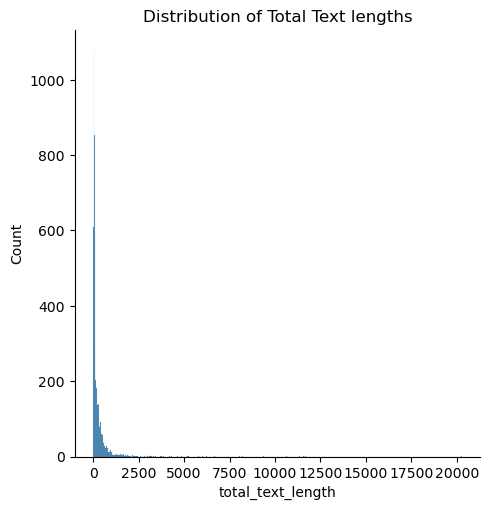

In [46]:
sns.displot(subreddit_df['total_text_length']).set(title = 'Distribution of Total Text lengths');
plt.show()


In [47]:
# `tokenized` Top 5 Highest Word Count
subreddit_df['tokenized'].str.len().sort_values(ascending=False).head()

250     3985
933     2169
1753    2078
2015    2004
2594    2003
Name: tokenized, dtype: int64

In [48]:
# `tokenized` Top 5 Shortest Word Count
subreddit_df['tokenized'].str.len().sort_values(ascending=True).head()

4688    0
694     0
433     0
4254    0
5132    1
Name: tokenized, dtype: int64

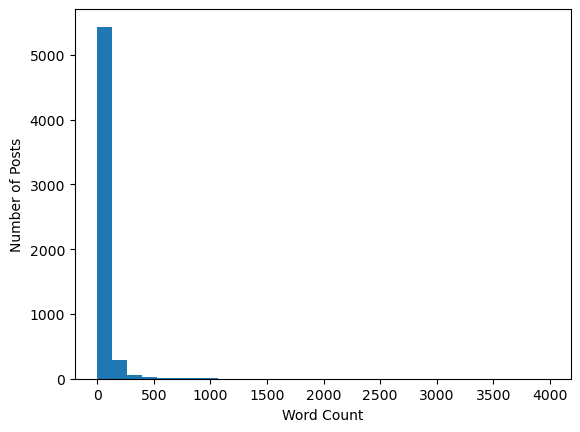

In [49]:
# Histogram of Word Count for `tokenized_sentences`
plt.hist(subreddit_df['tokenized'].str.len(), bins=30)
plt.ylabel('Number of Posts')
plt.xlabel('Word Count')
plt.show();

This histogram shows that mosts posts were under 100 word count

In [50]:
subreddit_df.head(1)

,subreddit,selftext,title,label,total_text,tokenized,total_text_length,total_text_word_count
0,nba,[**Ra asked me**](https://mediumlights.substac...,OC: Rookies Adjusting To The NBA (easier for s...,1,OC: Rookies Adjusting To The NBA (easier for s...,"[oc:, rookies, adjusting, to, the, nba, (easie...",6020,1050


In [51]:
# `total_text_length` Top 5 Longest Length Count
subreddit_df['total_text_length'].sort_values(ascending=False).head()

250     20260
933     12758
1753    11868
662     11669
2594    11573
Name: total_text_length, dtype: int64

In [52]:
# `total_text_length` Top 5 Shortest Length Count
subreddit_df['total_text_length'].sort_values(ascending=True).head()

4688    1
4254    1
694     1
433     1
5224    2
Name: total_text_length, dtype: int64

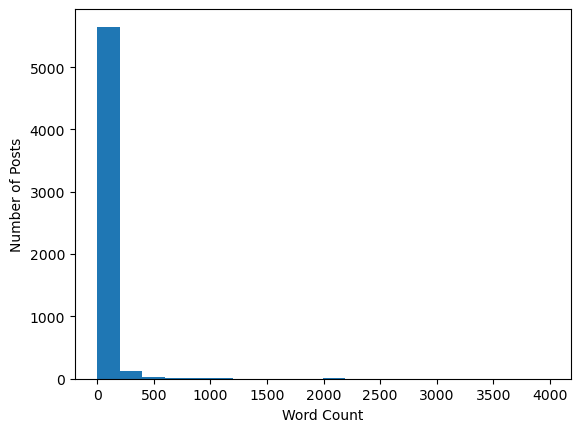

In [53]:
# Histogram of `total_text` Word Count
plt.hist(subreddit_df['total_text_word_count'], bins=20)
plt.ylabel('Number of Posts')
plt.xlabel('Word Count')
plt.show();

Since this size of the graph makes it difficult to see, I will split the histogram into 2 plots.  One with under than 
100 word count, and one greater than 100 word count.  This allow me to visualize this relationship better
and look for outliers.

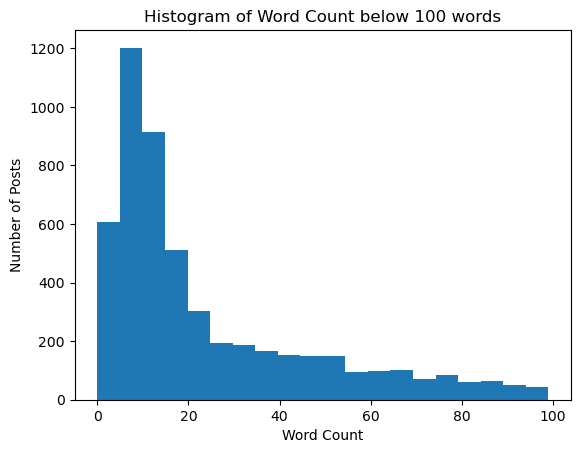

In [54]:
#Below 100 word count

Below_100 = subreddit_df[subreddit_df['total_text_word_count'] < 100]

plt.hist(Below_100['total_text_word_count'], bins=20)
plt.ylabel('Number of Posts')
plt.xlabel('Word Count')
plt.title('Histogram of Word Count below 100 words')
plt.show();

This histogram shows a a right skewness adn that the most of the posts have a word count between 0-20.

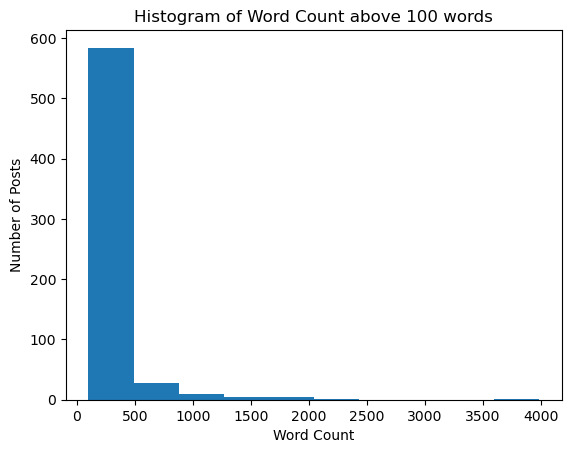

In [55]:
#More than 100 word count

Greater_100 = subreddit_df[subreddit_df['total_text_word_count'] > 100]

plt.hist(Greater_100['total_text_word_count'], bins=10)
plt.ylabel('Number of Posts')
plt.xlabel('Word Count')
plt.title('Histogram of Word Count above 100 words')
plt.show();

This graph shows the word count for posts over 100 word count.  These two graphs show that most posts are under
20 word count. 

In [56]:
subreddit_df.groupby(['subreddit'])['total_text_word_count', 'total_text_length'].mean().round(2)


C:\Users\ianst\AppData\Local\Temp\ipykernel_21820\3273767297.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  subreddit_df.groupby(['subreddit'])['total_text_word_count', 'total_text_length'].mean().round(2)


,total_text_word_count,total_text_length
subreddit,,
nba,66.08,388.62
nhl,28.99,160.65


This table here shows that the nba subreddit tends to have a higher word count avg. and total text length avg.
compared to the nhl subreddit.

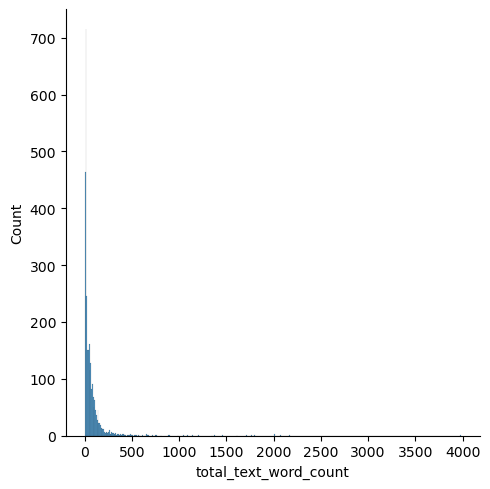

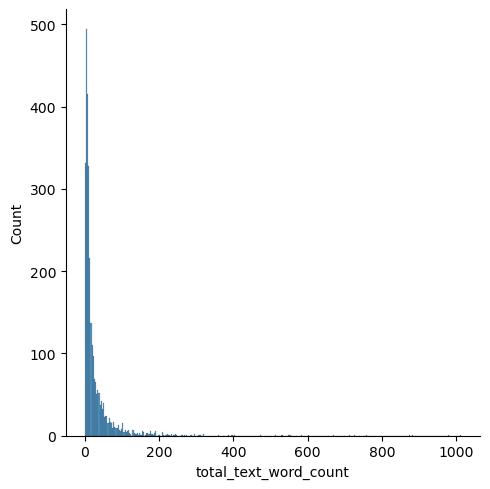

In [57]:
sns.displot(subreddit_df[subreddit_df['subreddit'] == 'nba']['total_text_word_count'])
sns.displot(subreddit_df[subreddit_df['subreddit'] == 'nhl']['total_text_word_count'])
plt.show();

Distribution plot of both subreddit's overlapped on the same graph

## PreProcessing and Modeling

In [58]:
# define X and y
X=subreddit_df['total_text']
y=subreddit_df['label']

In [59]:
X.head(2)

0    OC: Rookies Adjusting To The NBA (easier for s...
1    One of the highest upvoted posts and greatest ...
Name: total_text, dtype: object

In [60]:
# Split the data into the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state = 42)

In [61]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4671,), (1168,), (4671,), (1168,))

In [62]:
# Baseline:
y_train.value_counts(normalize=True)

0    0.505673
1    0.494327
Name: label, dtype: float64

In [63]:

y_test.value_counts(normalize=True)

0    0.505993
1    0.494007
Name: label, dtype: float64

In [64]:
# Instantiate a baseline CountVectorizer
# stop_words as hyperparameter
cvec = CountVectorizer(stop_words= 'english')

In [65]:
# Fit the Vectorizer
cvec.fit(X_train)

CountVectorizer(stop_words='english')

In [66]:
# Transform Corpus
X_train_countvec = cvec.transform(X_train)

In [67]:
X_train_countvec

<4671x13283 sparse matrix of type '<class 'numpy.int64'>'
	with 90796 stored elements in Compressed Sparse Row format>

In [68]:
# Sparse to Dense Representation
X_train_countvec.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

#### CountVectorizer

C:\Users\ianst\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


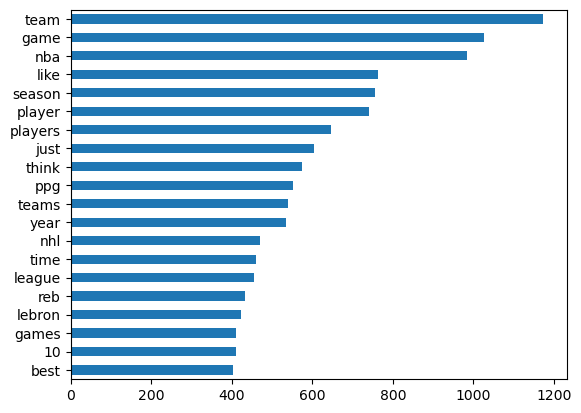

In [69]:
# Dataframe for CountVectorizer
subreddit_df_train_wordcount = pd.DataFrame(X_train_countvec.todense(), columns = cvec.get_feature_names())

# Transform test
X_test_countvec = cvec.transform(X_test)

# Bar Graph of Top 20 Words
subreddit_df_train_wordcount.sum().sort_values(ascending=False).head(20).sort_values(ascending=True).plot(kind='barh')
plt.show();

The bar graph above shows the top 20 words using Count Vectorizer with stop words as the only hyper parameter.
We see that the top two words are 'team' and 'game'.  This makes sense as in both the nba and nhl subreddit,
both of these vocabulary words are used. 

#### TF-IDF Vectorizer

C:\Users\ianst\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


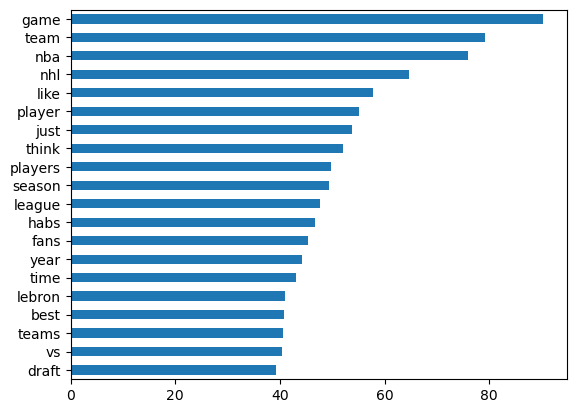

In [70]:
# Instantiate TF-IDF Vectorizer
tvec = TfidfVectorizer(stop_words = 'english')
# Convert Training Data to Dataframe
X_train_tfidf = pd.DataFrame(tvec.fit_transform(X_train).todense(),
                          columns = tvec.get_feature_names())

# Bar Graph of Top 20 Words
X_train_tfidf.sum().sort_values(ascending=False).head(20).sort_values(ascending=True).plot(kind='barh')
plt.show();

The bar graph above shows the top 20 words using TF-IDF Vectorizer with stop words as the only hyper parameter.
We see that the top two words are 'team' and 'game'.  Compared to count vertiorizer though, the word 'nhl' appeared
in the top 4.

Out of the two types of vectorizer's, I believe the Tf-IDF Vectorizer is better as it also consider the overall document
weightage of the words.  In the Tf-IDF bar graph, 'nhl' is included which I think is import as 'nba' is also included.
It is important that both subreddit titles appear and weighted appropriately. 

I will uses Tf-IDF vectorizer for my modeling based off of this.

Histogram of frequency of most poplular word count

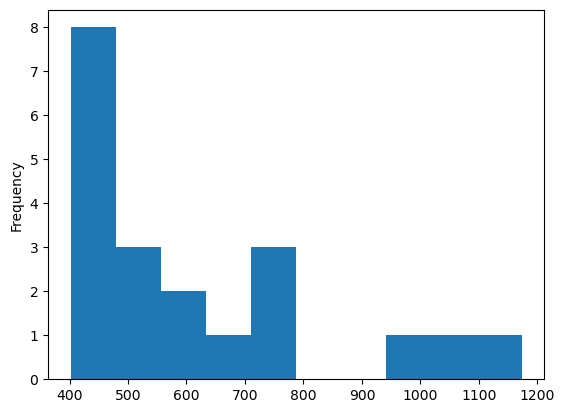

In [71]:
subreddit_df_train_wordcount.sum().sort_values(ascending=False).head(20).sort_values(ascending=True).plot(kind='hist')
plt.show();


The histogram above shows the top 20 word count.  There seems to be a gap between the top 3 and the rest.

In [72]:
# https://gist.github.com/balapriyac/06c97a6f31973c9dba7402b93272038b
# https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools


def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    sub_post= text.str.split()#Split text into string
    sub_post=sub_post.values.tolist()#insert strings in a list of list
    corpus=[word for i in sub_post for word in i]#Combine lists into 1 list

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)#Fit CountVectorizer
        bag_of_words = vec.transform(corpus)# Transform CountVectorizer
        sum_words = bag_of_words.sum(axis=0) #Sum of Transformed CountVectorizers
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]#sum count of words based off of what n=
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)#Sort via highest frequency
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

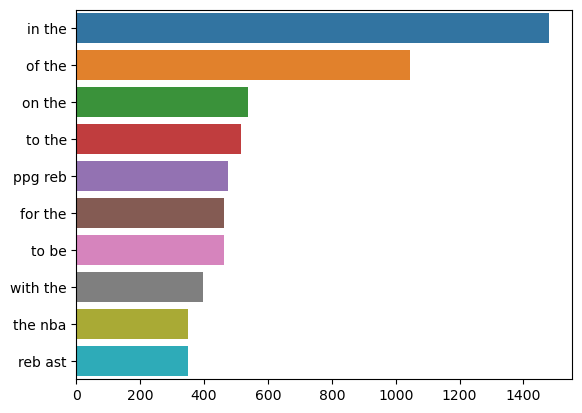

In [73]:
plot_top_ngrams_barchart(subreddit_df['total_text'], 2)
plt.show();

The above bar chart is a of bigrams based off off the two subreddit's nhl and nba.  This visual allows me to see
what group of two words are most commonly used.  It looks like the bottom half of the graph tends to have a lot
of words related to the r/nba reddit (ppg reb, the nba, reb ast).  The most common bigram was 'in the'.

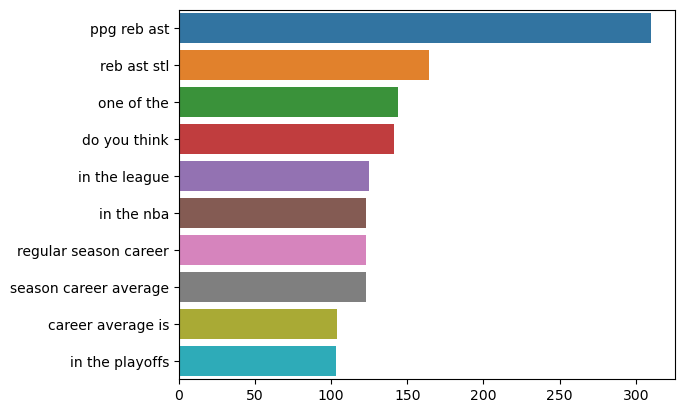

In [74]:
plot_top_ngrams_barchart(subreddit_df['total_text'], 3)
plt.show();

The above chart is a tri-gram bargraph of the data set.  The top tri-gram is also related ot the r/nba: points per game,
rebounds, and assists.

In [75]:
from textblob import TextBlob

In [76]:
def plot_polarity_histogram(text):
    
    def _polarity(text):
        return TextBlob(text).sentiment.polarity
        
    polarity_score =text.apply(lambda x : _polarity(x))
    polarity_score.hist()

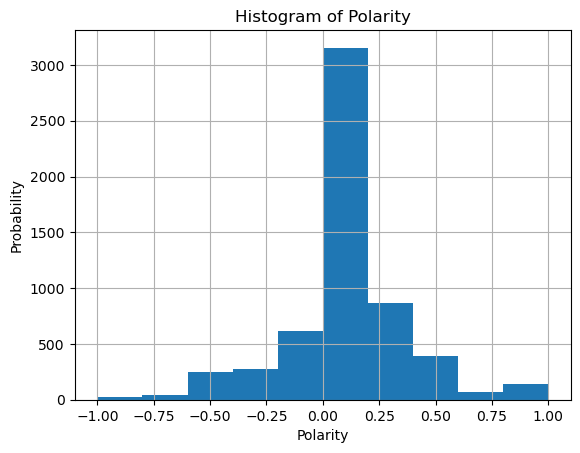

In [79]:
plot_polarity_histogram(subreddit_df['total_text'])
plt.xlabel('Polarity')
plt.ylabel('Probability')
plt.title('Histogram of Polarity')
plt.show();

After importing TextBlob, a Lexicon-based sentiment analyzer, I did some sentiment analysis on the dataset and created
a histogram of the calculated values.  We can see that the polarity mostly ranges from 0.00 and 0.2.  This means the 
majority of the two subreddit's are neutral. 

In [77]:
subreddit_df.reset_index(drop=True, inplace=True)

In [78]:
# Instantiate Sentiment Analysis
sent = SentimentIntensityAnalyzer()

# Top 5 Negative Scores
# https://stackoverflow.com/questions/39462021/nltk-sentiment-vader-polarity-scorestext-not-working

polarity_scores = pd.DataFrame([sent.polarity_scores(subreddit_df['total_text'][i]) for i in range(len(subreddit_df['total_text']))])
polarity_scores['neg'].nlargest(n=5)

3939    1.000
4875    1.000
5773    1.000
5287    0.884
3664    0.810
Name: neg, dtype: float64

In [79]:
print(subreddit_df['total_text'][3939])
print(subreddit_df['total_text'][4875])
print(subreddit_df['total_text'][5773])
print(subreddit_df['total_text'][5287])
print(subreddit_df['total_text'][3664])

Fatality. 
Disappoint. 
Disappointment 
Savage as hell. 
FAKE NEWS!!!! 


In [80]:
print(subreddit_df['subreddit'][3939])
print(subreddit_df['subreddit'][4875])
print(subreddit_df['subreddit'][5773])
print(subreddit_df['subreddit'][5287])
print(subreddit_df['subreddit'][3664])

nhl
nhl
nhl
nhl
nhl


Above show the top 5 negative polarity scores, with scores ranging from  0.81 to 1.0, and all were in r/nhl posts.

## Modeling

### MNB
#### IF-IDF Vectorizer

In [81]:
tvec_pipe = Pipeline([
    ('tvec' , TfidfVectorizer(stop_words = 'english')),
    ('mnb', MultinomialNB())
])

pipe_tvec_params = {
    'tvec__max_features': [2000, 3000, 4000, 5000],
    'tvec__stop_words': [None, 'english'],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)]
}

# Gridsearch MNB
mnb_gs = GridSearchCV(tvec_pipe, pipe_tvec_params, cv=5, verbose=1)
# Fit GridSearch to Training Data
mnb_gs.fit(X_train, y_train)
mnb_gs.best_params_


Fitting 5 folds for each of 64 candidates, totalling 320 fits


{'tvec__max_df': 0.9,
 'tvec__max_features': 5000,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

In [82]:
# Multinomial Naive Bayes (IF-IDF Vectorizer) Best Score
print(mnb_gs.best_score_)

0.9265673487615798


In [83]:
# IF-IDF Vectorizer Best Score with Parameters
print(f'Multinomial Naive Bayes (IF-IDF Vectorizer) Train Score: {mnb_gs.score(X_train, y_train)}')
print(f'Multinomial Naive Bayes (IF-IDF Vectorizer) Test Score: {mnb_gs.score(X_test, y_test)}')

Multinomial Naive Bayes (IF-IDF Vectorizer) Train Score: 0.9565403553842861
Multinomial Naive Bayes (IF-IDF Vectorizer) Test Score: 0.9272260273972602


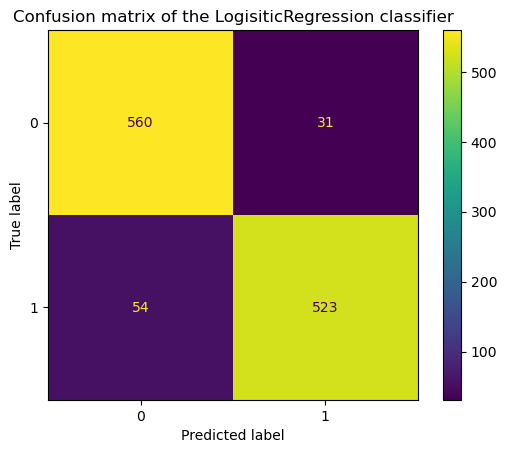

In [84]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = mnb_gs.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()

plt.title('Confusion matrix of the Mulitnomial Baye classifier')
plt.show()

In [85]:
print(f'Multinomial Naive Bayes (TF-IDF Vectorizer) Specificity: {tn / (tn + fp)}')
print(f'Multinomial Naive Bayes (TF-IDF Vectorizer) Sensitivity: {tp / (tp + fn)}')

Multinomial Naive Bayes (TF-IDF Vectorizer) Specificity: 0.9475465313028765
Multinomial Naive Bayes (TF-IDF Vectorizer) Sensitivity: 0.9064124783362218


### MNB
#### MNB Count Vectorizer

In [86]:
cvec_pipe = Pipeline([
    ('cvec' , CountVectorizer(stop_words = 'english')),
    ('mnb', MultinomialNB())
])

pipe_cvec_params = {
    'cvec__max_features': [2000, 3000, 4000, 5000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': [None, 'english'],
}

# Gridsearch MNB
mnb_gs2 = GridSearchCV(cvec_pipe, pipe_cvec_params, cv=5, verbose=1)
# Fit GridSearch to Training Data
mnb_gs2.fit(X_train, y_train)
mnb_gs2.best_params_


Fitting 5 folds for each of 64 candidates, totalling 320 fits


{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english'}

In [87]:
# Multinomial Naive Bayes (Count Vectorizer) Best Score
print(mnb_gs2.best_score_)

0.9212154038177467


In [88]:
# Count Vectorizer Best Score with Parameters
print(f'Multinomial Naive Bayes (Count Vectorizer) Train Score: {mnb_gs2.score(X_train, y_train)}')
print(f'Multinomial Naive Bayes (Count Vectorizer) Test Score: {mnb_gs2.score(X_test, y_test)}')

Multinomial Naive Bayes (Count Vectorizer) Train Score: 0.9466923570969814
Multinomial Naive Bayes (Count Vectorizer) Test Score: 0.9238013698630136


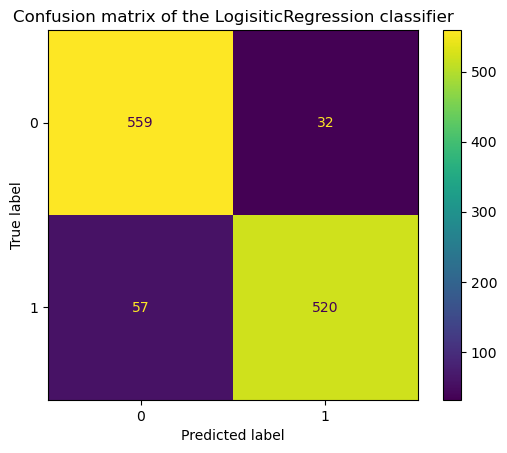

In [89]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = mnb_gs2.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()

plt.title('Confusion matrix of the LogisiticRegression classifier')
plt.show()

In [90]:
print(f'Multinomial Naive Bayes (TF-IDF Vectorizer) Specificity: {tn / (tn + fp)}')
print(f'Multinomial Naive Bayes (TF-IDF Vectorizer) Sensitivity: {tp / (tp + fn)}')

Multinomial Naive Bayes (TF-IDF Vectorizer) Specificity: 0.9458544839255499
Multinomial Naive Bayes (TF-IDF Vectorizer) Sensitivity: 0.901213171577123


#### Predicted vs. Actural Results

In [91]:
y_test_mnb = pd.DataFrame(y_test.reset_index())
y_test_mnb['y_test_df_predicted'] = y_pred
y_test_mnb

,index,label,y_test_df_predicted
0,18,1,0
1,4871,0,0
2,5954,0,0
3,5168,0,0
4,3320,0,0
...,...,...,...
1163,4672,0,0
1164,2044,1,1
1165,4927,0,0
1166,5493,0,0


In [92]:
y_test_mnb[y_test_mnb['y_test_df_predicted'] != y_test_mnb['label']]


,index,label,y_test_df_predicted
0,18,1,0
10,2277,1,0
18,5932,0,1
32,1903,1,0
60,941,1,0
...,...,...,...
1125,1487,1,0
1129,4010,0,1
1131,3865,0,1
1140,5564,0,1


In [93]:
print(subreddit_df['total_text'][18])
# Thought it was r/nhl but it was not

[Overtime/Twitter] Kevon Looney getting cooked at his own camp 


In [94]:
print(subreddit_df['total_text'][4010])
# Thought it was r/nba but it was not

[Sean Shapiro on Twitter] Since everyone asks, from what I've heard ESPN didn't seriously consider bringing back Gary Thorne. 


### Logistic Regression
#### Count Vectorizer

In [95]:
pipe_lr_c = Pipeline([
    ('cvec', CountVectorizer(stop_words='english', ngram_range=(1,2))),
    ('lr', LogisticRegression(solver='liblinear', max_iter=5000))
])

# Set up pipeline params
pipe_lr_c_params = {
    'cvec__max_features': [200, 500]}

In [96]:
logreg_gs = GridSearchCV(pipe_lr_c, pipe_lr_c_params, cv=5, verbose=1)


logreg_gs.fit(X_train, y_train);

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [97]:
print(f'Logisitc Regression Count Vectorizer Best Score: {logreg_gs.best_score_}')
print(f'Logisitc Regression Count Vectorizer Train Score: {logreg_gs.score(X_train, y_train)}')
print(f'Logisitc Regression Count Vectorizer Test Score: {logreg_gs.score(X_test, y_test)}')
print(f'Logisitc Regression Count Vectorizer Best Parameters: {logreg_gs.best_params_}')

Logisitc Regression Count Vectorizer Best Score: 0.8890996118127997
Logisitc Regression Count Vectorizer Train Score: 0.9291372297152644
Logisitc Regression Count Vectorizer Test Score: 0.9083904109589042
Logisitc Regression Count Vectorizer Best Parameters: {'cvec__max_features': 500}


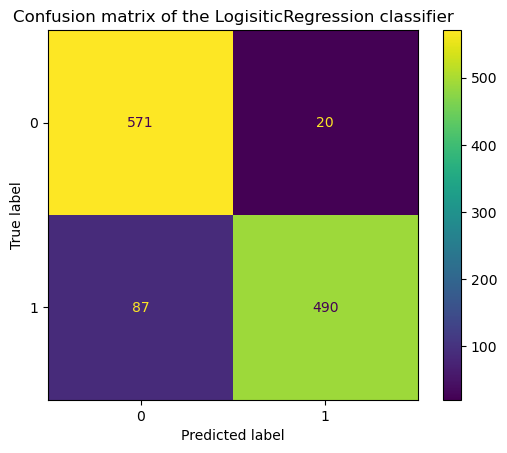

In [98]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = logreg_gs.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()

plt.title('Confusion matrix of the LogisiticRegression classifier')
plt.show()

In [99]:
print(f'Logistic Regression (Count Vectorizer Specificity): {tn / (tn + fp)}')
print(f'Logistic Regression (Count Vectorizer Sensitivity): {tp / (tp + fn)}')

Logistic Regression (Count Vectorizer Specificity): 0.9661590524534687
Logistic Regression (Count Vectorizer Sensitivity): 0.8492201039861352


### Logistic Regression
#### TF-IDF Vectorizer

In [100]:
pipe_lr_t = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
    ('lr', LogisticRegression(solver='liblinear', max_iter=5000))
])

# Set up pipeline params
pipe_lr_t_params = {
    'cvec__max_features': [200, 500]}

In [101]:
logreg_gs_2 = GridSearchCV(pipe_lr_c, pipe_lr_c_params, cv=5, verbose=1)


logreg_gs_2.fit(X_train, y_train);

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [102]:
print(f'Logisitc Regression IF-IDF Vectorizer Best Score: {logreg_gs_2.best_score_}')
print(f'Logisitc Regression IF-IDF Vectorizer Train Score: {logreg_gs_2.score(X_train, y_train)}')
print(f'Logisitc Regression IF-IDF Vectorizer Test Score: {logreg_gs_2.score(X_test, y_test)}')
print(f'Logisitc Regression IF-IDF Vectorizer Best Parameters: {logreg_gs_2.best_params_}')

Logisitc Regression IF-IDF Vectorizer Best Score: 0.8890996118127997
Logisitc Regression IF-IDF Vectorizer Train Score: 0.9291372297152644
Logisitc Regression IF-IDF Vectorizer Test Score: 0.9083904109589042
Logisitc Regression IF-IDF Vectorizer Best Parameters: {'cvec__max_features': 500}


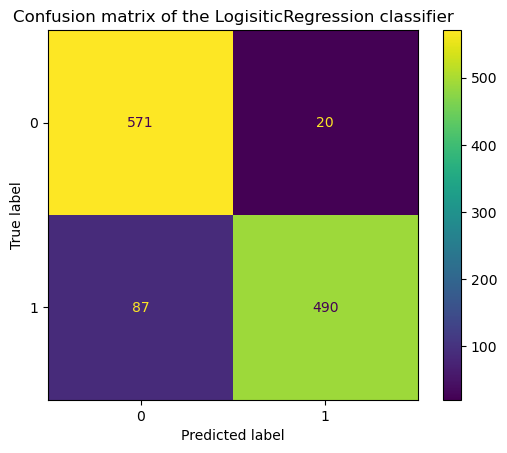

In [103]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = logreg_gs_2.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()

plt.title('Confusion matrix of the LogisiticRegression classifier')
plt.show()

In [104]:
print(f'TF-IDF Vectorizer Specificity: {tn / (tn + fp)}')
print(f'TF-IDF Vectorizer Sensitivity: {tp / (tp + fn)}')

TF-IDF Vectorizer Specificity: 0.9661590524534687
TF-IDF Vectorizer Sensitivity: 0.8492201039861352


In [105]:
y_test_mnb_2 = pd.DataFrame(y_test.reset_index())
y_test_mnb_2['y_test_df_predicted'] = y_pred
y_test_mnb_2

,index,label,y_test_df_predicted
0,18,1,0
1,4871,0,0
2,5954,0,0
3,5168,0,0
4,3320,0,0
...,...,...,...
1163,4672,0,0
1164,2044,1,1
1165,4927,0,0
1166,5493,0,0


In [106]:
y_test_mnb_2[y_test_mnb_2['y_test_df_predicted'] != y_test_mnb_2['label']]


,index,label,y_test_df_predicted
0,18,1,0
7,731,1,0
10,2277,1,0
23,446,1,0
27,4213,0,1
...,...,...,...
1111,338,1,0
1121,1867,1,0
1125,1487,1,0
1127,294,1,0


In [107]:
print(subreddit_df['total_text'][1390])
# Thought it was r/nba but it was not

2 Months Ago on June 15, 2021, The Bucks Were Up 17 In The 3rd Quarter And Lost Game #5 By 6 Points To The Nets 108-114. Budenholzer's Wiki Page Had Nearly 100 Edits In 24 Hours 


### K-nearest Neighbors
#### Count Vectorizer

In [108]:
# Set up pipeline
pipe_knn_c = Pipeline([
    ('cvec', CountVectorizer(stop_words='english', ngram_range=(1,2))),
    ('knn', KNeighborsClassifier())
])


# Set up pipeline params
pipe_knn_c_params = {
    'cvec__max_features': [200, 500],
    'knn__n_neighbors':[5, 15, 25, 35, 45],
    'knn__p': [1, 2]
}

In [109]:
# Set up a gridsearch
gs_knn_c = GridSearchCV(pipe_knn_c, pipe_knn_c_params, cv=5, verbose=1)

# Fit the gridsearch
gs_knn_c.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [110]:
print(f'K-nearest Neighbors Count Vectorizer Best Score: {gs_knn_c.best_score_}')
print(f'K-nearest Neighbors Count Vectorizer Train Score: {gs_knn_c.score(X_train, y_train)}')
print(f'K-nearest Neighbors Count Vectorizer Test Score: {gs_knn_c.score(X_test, y_test)}')
print(f'K-nearest Neighbors Count Vectorizer Best Parameters: {gs_knn_c.best_params_}')

K-nearest Neighbors Count Vectorizer Best Score: 0.762788535309004
K-nearest Neighbors Count Vectorizer Train Score: 0.8447869835153072
K-nearest Neighbors Count Vectorizer Test Score: 0.7773972602739726
K-nearest Neighbors Count Vectorizer Best Parameters: {'cvec__max_features': 500, 'knn__n_neighbors': 5, 'knn__p': 2}


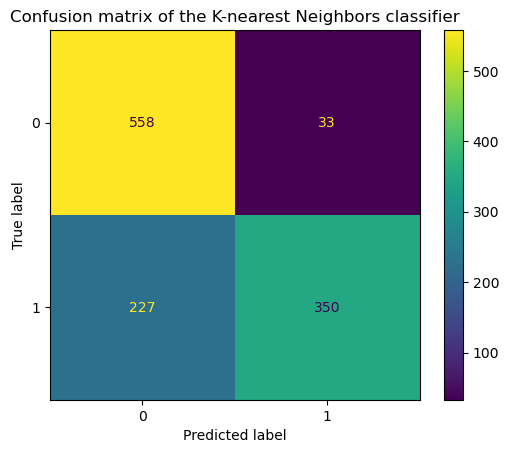

In [111]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = gs_knn_c.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()

plt.title('Confusion matrix of the K-nearest Neighbors classifier')
plt.show()

In [112]:
print(f'TF-IDF Vectorizer Specificity: {tn / (tn + fp)}')
print(f'TF-IDF Vectorizer Sensitivity: {tp / (tp + fn)}')

TF-IDF Vectorizer Specificity: 0.9441624365482234
TF-IDF Vectorizer Sensitivity: 0.6065857885615251


### K-nearest Neighbors
#### TF-IDF Vectorizer

In [113]:
# Set up pipeline
pipe_knn_t = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english',ngram_range=(1,2))),
    ('knn', KNeighborsClassifier())
])


# Set up pipeline params
pipe_knn_t_params = {
    'knn__n_neighbors':[5, 15, 25, 35, 45],
    'knn__p': [1, 2]
}

In [114]:
# Set up a gridsearch
gs_knn_t = GridSearchCV(pipe_knn_t, pipe_knn_t_params, cv=5, verbose=1)

# Fit the gridsearch
gs_knn_t.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [115]:
print(f'K-nearest Neighbors IF-IDF Vectorizer Best Score: {gs_knn_t.best_score_}')
print(f'K-nearest Neighbors IF-IDF Vectorizer Train Score: {gs_knn_t.score(X_train, y_train)}')
print(f'K-nearest Neighbors IF-IDF Vectorizer Test Score: {gs_knn_t.score(X_test, y_test)}')
print(f'K-nearest Neighbors IF-IDF Vectorizer Best Parameters: {gs_knn_t.best_params_}')

K-nearest Neighbors IF-IDF Vectorizer Best Score: 0.6912869722543485
K-nearest Neighbors IF-IDF Vectorizer Train Score: 0.5056733033611647
K-nearest Neighbors IF-IDF Vectorizer Test Score: 0.5059931506849316
K-nearest Neighbors IF-IDF Vectorizer Best Parameters: {'knn__n_neighbors': 45, 'knn__p': 2}


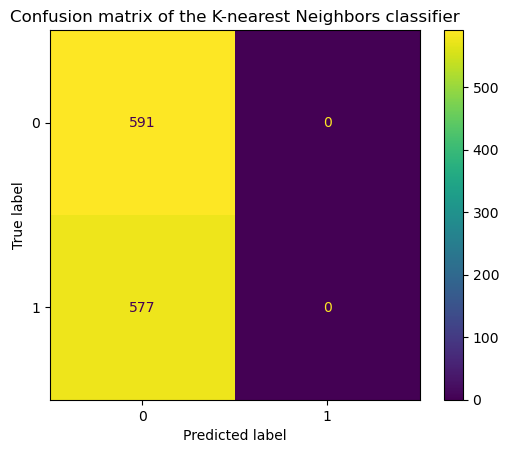

In [116]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = gs_knn_t.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()

plt.title('Confusion matrix of the K-nearest Neighbors classifier')
plt.show()

In [117]:
print(f'TF-IDF Vectorizer Specificity: {tn / (tn + fp)}')
print(f'TF-IDF Vectorizer Sensitivity: {tp / (tp + fn)}')

TF-IDF Vectorizer Specificity: 1.0
TF-IDF Vectorizer Sensitivity: 0.0


In [118]:
y_test_mnb_3 = pd.DataFrame(y_test.reset_index())
y_test_mnb_3['y_test_df_predicted'] = y_pred
y_test_mnb_3

,index,label,y_test_df_predicted
0,18,1,0
1,4871,0,0
2,5954,0,0
3,5168,0,0
4,3320,0,0
...,...,...,...
1163,4672,0,0
1164,2044,1,0
1165,4927,0,0
1166,5493,0,0


In [119]:
y_test_mnb_3[y_test_mnb_3['y_test_df_predicted'] != y_test_mnb_3['label']]


,index,label,y_test_df_predicted
0,18,1,0
5,1390,1,0
6,2301,1,0
7,731,1,0
8,2122,1,0
...,...,...,...
1160,997,1,0
1161,2865,1,0
1162,2395,1,0
1164,2044,1,0


In [120]:
print(subreddit_df['total_text'][1390])
# Thought it was r/nba but it was not

2 Months Ago on June 15, 2021, The Bucks Were Up 17 In The 3rd Quarter And Lost Game #5 By 6 Points To The Nets 108-114. Budenholzer's Wiki Page Had Nearly 100 Edits In 24 Hours 


| Model | Train Score | Test Score | Sensitivity | Specificity |
| --- | --- | --- | --- | --- |
| Multinomial Bayes (Count Vectorizer) | 0.946 | 0.923 | 0.901 | 0.945 |
| Multinomial Bayes (TF-IDF Vectorizer) | 0.956 | 0.927 | 0.906 | 0.947 |
| K-Nearest Neighbor (Count Vectorizer) | 0.844 | 0.777 | 0.606 | 0.944 |
| K-Nearest Neighbor (IF-IDF Vectorizer) | 0.505 | 0.505 | 1.0 | 0.0 |
| Logistic Regression (Count Vectorizer) | 0.929 | 0.908 | 0.849 | 0.966 |
| Logistic Regression (IF-IDF Vectorizer) | 0.929 | 0.908 | 0.849 | 0.966 |

The models listed in the table I ran with gridsearch

# Conclusion and Reccomendations

Overall I would conclude that my models are overfit based on the Train RMSE being greater than the Test RMSE in all but
one model.  I think this had to do with the fact that "nba" or "nhl" must have occured in many of the subreddit
posts.

I found that Multinomial Bayes was the best model, specfically the one used with TF-IDF Vectorizer.  I also found the
sensitivity, the probability of a positive test, and the specificity, the pprobaility of a negative test.  In my model I
had a positive test be 1, which is correctly identifying the subreddit was r/nba.  For both Multinomial Bayes
model, the specificity was higher than the sensitivity.

Futhermore, I created a y-actual vs. y-pred table to see what rows my model predicted wrong and the text it 
went off.  I saw that a lot of my errors had to do with professional athlete names.  I also saw that some of the posts
had words that could be used in both subreddit's such as the words: 'game', 'score', and 'points'.

In Conclusion, based off my Multinomial Bayes (TF-IDF Vectorizer) model, I would conclude that the users posts are 
indeed be posted on the correct subreddit.  NBA related posts are being posted on r/nba and NHL related posts
are being posted on r/NHL.  Both of these professional sports leage reddit pages are running correctly.

Next Steps:
    - adjust stop words: adjust common words such as: 'game', 'score', and 'points'
    - more cleaning on emoji's, pictures, and videos in subreddit posts
    - adjust the names of professional atheltes quoted in subreddit posts